### Data preprocessing of LinkedIn Job Postings Dataset
#### Setup and Library Installation

In [235]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [236]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [237]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Library Imports



In [238]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import re

#### Loading Data

In [239]:
# Load datasets from the CSV files for analysis.
job_postings = pd.read_csv('data/job_postings.csv')
job_skills = pd.read_csv('data/job_details/job_skills.csv')

companies = pd.read_csv('data/company_details/companies.csv')
mapping_skills = pd.read_csv('data/maps/skills.csv')

#### Dataset summary

In [240]:
unique_values = {
    'job_postings': job_postings['job_id'].nunique(), # details of job postings
    'job_skills': job_skills['job_id'].nunique(), # job posting with the required skill abbreviated
    'companies': companies['company_id'].nunique(), # information on the company
    'skills': mapping_skills['skill_name'].nunique() # maps between skill abbreviations and full skill names
    }
unique_values

{'job_postings': 33246, 'job_skills': 32422, 'companies': 11361, 'skills': 35}

#### Handling the integration of job_skills with mapping_skills
Merging job_skills with mapping_skills

In [241]:
# Merging job_skills with mapping_skills to replace skill_abr with skill_name
merged_skills = pd.merge(job_skills, mapping_skills, on='skill_abr', how='left')
merged_skills = merged_skills.drop('skill_abr', axis=1)
merged_skills.head()

,job_id,skill_name
0,3690843087,Accounting/Auditing
1,3690843087,Finance
2,3691763971,Management
3,3691763971,Manufacturing
4,3691775263,Management


In [242]:
merged_skills.shape

(56591, 2)

Aggregating Skills by Job ID

In [243]:
# Aggregation process is done to handle duplicate 'job_id's resulting from multiple skills per job:

# Grouping by 'job_id' and concatenating 'skill_name' values
grouped_skills = merged_skills.groupby('job_id')['skill_name'].agg(lambda x: ', '.join(x)).reset_index()

# Display the resulting DataFrame with unique 'job_id' rows and concatenated skills
print(grouped_skills)

           job_id                                    skill_name
0         3958427  Design, Art/Creative, Information Technology
1        85008768                   Sales, Business Development
2       102339515                   Business Development, Sales
3       108965123                                Administrative
4       133114754                   Sales, Business Development
...           ...                                           ...
32417  3757937095                        Information Technology
32418  3757938018                     Management, Manufacturing
32419  3757938019                                   Engineering
32420  3757940025                     Management, Manufacturing
32421  3757940104                                         Other

[32422 rows x 2 columns]


#### Handling the integration of job_postings with grouped_skills
Checking for missing data in Company ID's

In [244]:
missing_id = job_postings['company_id'].isnull().sum()
missing_id

654

Dropping rows with empty company_id's

In [245]:
# Shape of dataset before removing missing values
job_postings.shape

(33246, 28)

In [246]:
# Inplace = True operation will modify the DataFrame job_postings in place, and the changes will be applied directly to it 
# without the need to reassign the result to a new variable.
job_postings.dropna(subset=['company_id'], inplace=True)
job_postings.shape

(32592, 28)

In [247]:
missing_id = job_postings['company_id'].isnull().sum()
missing_id

0

Merging job_postings with grouped_skills

In [248]:
merged_job_postings_skills = pd.merge(job_postings, grouped_skills, on='job_id', how='left')

Converting company data type to int from float

In [249]:
# Because there used to be missing values in company id's, NaN was considered as float value, therefore all data in the column was converted
# to float from int
if 'company_id' in merged_job_postings_skills.columns:
    merged_job_postings_skills['company_id'] = merged_job_postings_skills['company_id'].astype('Int64')

In [250]:
merged_job_postings_skills.head()

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,scraped,skill_name
0,3757940104,553718,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,NaN,5250.00,NaN,MONTHLY,Full-time,"Little River, SC",...,Entry level,NaN,1.699090e+12,careers-demant.icims.com,0,FULL_TIME,USD,BASE_SALARY,1699138101,Other
1,3757940025,2192142,Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,NaN,NaN,NaN,NaN,Full-time,"Beaver Dam, WI",...,NaN,NaN,1.699080e+12,www.click2apply.net,0,FULL_TIME,NaN,NaN,1699085420,"Management, Manufacturing"
2,3757938019,474443,"Manager, Engineering",\nThe TSUBAKI name is synonymous with excellen...,NaN,NaN,NaN,NaN,Full-time,"Bessemer, AL",...,NaN,Bachelor's Degree in Mechanical Engineering pr...,1.699080e+12,www.click2apply.net,0,FULL_TIME,NaN,NaN,1699085644,Engineering
3,3757938018,18213359,Cook,descriptionTitle\n\n Looking for a great oppor...,NaN,22.27,NaN,HOURLY,Full-time,"Aliso Viejo, CA",...,Entry level,NaN,1.699080e+12,jobs.apploi.com,0,FULL_TIME,USD,BASE_SALARY,1699087461,"Management, Manufacturing"
4,3757937095,437225,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",275834.0,NaN,205956.0,YEARLY,Full-time,United States,...,Mid-Senior level,NaN,1.699090e+12,careers.iherb.com,0,FULL_TIME,USD,BASE_SALARY,1699085346,Information Technology


Reducing dimensionality of merged_job_postings_skills by dropping unnecessary columns

In [251]:
columns_to_drop = ['description', 'max_salary','med_salary','min_salary',
                   'pay_period', 'applies', 'formatted_work_type', 'remote_allowed',
                   'job_posting_url','views','title','application_url','application_type',
                   'expiry','skills_desc','posting_domain','sponsored','original_listed_time',
                   'work_type','currency','compensation_type','scraped','closed_time','listed_time'
                   ]
merged_job_postings_skills= merged_job_postings_skills.drop(columns=columns_to_drop,axis=1)
merged_job_postings_skills.head()


,job_id,company_id,location,formatted_experience_level,skill_name
0,3757940104,553718,"Little River, SC",Entry level,Other
1,3757940025,2192142,"Beaver Dam, WI",NaN,"Management, Manufacturing"
2,3757938019,474443,"Bessemer, AL",NaN,Engineering
3,3757938018,18213359,"Aliso Viejo, CA",Entry level,"Management, Manufacturing"
4,3757937095,437225,United States,Mid-Senior level,Information Technology


#### Handling the integration of merged_job_postings_skills with companies
Merging merged_job_postings_skills with companies


In [252]:
merged_data= pd.merge(merged_job_postings_skills, companies, on='company_id', how='left')
merged_data.head()

,job_id,company_id,location,formatted_experience_level,skill_name,name,description,company_size,state,country,city,zip_code,address,url
0,3757940104,553718,"Little River, SC",Entry level,Other,HearingLife,HearingLife is a national hearing care company...,5.0,New Jersey,US,Somerset,08873,580 Howard Avenue,https://www.linkedin.com/company/hearing-life
1,3757940025,2192142,"Beaver Dam, WI",NaN,"Management, Manufacturing","Metalcraft of Mayville, Inc.","Headquartered in Mayville, Wisconsin, Metalcra...",4.0,WI,US,Mayville,53050,1000 Metalcraft Drive,https://www.linkedin.com/company/metalcraft-of...
2,3757938019,474443,"Bessemer, AL",NaN,Engineering,"U.S. Tsubaki Power Transmission, LLC","U.S. Tsubaki Power Transmission, LLC is a subs...",4.0,Illinois,US,Wheeling,60090,301E Marquardt Drive,https://www.linkedin.com/company/u.s.-tsubaki-...
3,3757938018,18213359,"Aliso Viejo, CA",Entry level,"Management, Manufacturing",Episcopal Communities & Services,Episcopal Communities & Services (ECS) has bec...,4.0,California,US,Altadena,91001,2212 El Molino Ave,https://www.linkedin.com/company/episcopal-com...
4,3757937095,437225,United States,Mid-Senior level,Information Technology,"iHerb, LLC",iHerb is on a mission to make health and welln...,5.0,California,US,Irvine,92618,17400 Laguna Canyon Rd,https://www.linkedin.com/company/iherb


Reducing dimensionality by dropping unnecessary columns

In [253]:
columns_to_drop = ['description','company_size','zip_code','url','address','state','city']
merged_data= merged_data.drop(columns=columns_to_drop,axis=1)
merged_data.head()

,job_id,company_id,location,formatted_experience_level,skill_name,name,country
0,3757940104,553718,"Little River, SC",Entry level,Other,HearingLife,US
1,3757940025,2192142,"Beaver Dam, WI",NaN,"Management, Manufacturing","Metalcraft of Mayville, Inc.",US
2,3757938019,474443,"Bessemer, AL",NaN,Engineering,"U.S. Tsubaki Power Transmission, LLC",US
3,3757938018,18213359,"Aliso Viejo, CA",Entry level,"Management, Manufacturing",Episcopal Communities & Services,US
4,3757937095,437225,United States,Mid-Senior level,Information Technology,"iHerb, LLC",US


Displaying data in a better order

In [254]:
column_order = ['job_id','company_id','name','location','country','skill_name','formatted_experience_level']
merged_data = merged_data[column_order]
merged_data.head()

,job_id,company_id,name,location,country,skill_name,formatted_experience_level
0,3757940104,553718,HearingLife,"Little River, SC",US,Other,Entry level
1,3757940025,2192142,"Metalcraft of Mayville, Inc.","Beaver Dam, WI",US,"Management, Manufacturing",NaN
2,3757938019,474443,"U.S. Tsubaki Power Transmission, LLC","Bessemer, AL",US,Engineering,NaN
3,3757938018,18213359,Episcopal Communities & Services,"Aliso Viejo, CA",US,"Management, Manufacturing",Entry level
4,3757937095,437225,"iHerb, LLC",United States,US,Information Technology,Mid-Senior level


#### Identify remaining missing data in the merged dataset
Display columns with significant missing data

In [255]:
missing_data = merged_data.isnull().sum()
significant_missing_columns = missing_data[missing_data > 0].sort_values(ascending=True)
significant_missing_columns

country                         47
name                            51
skill_name                    1023
formatted_experience_level    8622
dtype: int64

Handling missing values of 'name' column

In [256]:
# After merging, 51 rows of company references in job_postings were non existent in the company id's dataset. 
missing_names = merged_data['name'].isnull().sum()

null_name_indices = merged_data[merged_data['name'].isnull()]['company_id']
print("Number of missing ID's:", missing_names)
print(null_name_indices)

Number of missing ID's: 51
7305     76999667
15698     3641332
15706     3641332
15968     3641332
16405     3641332
20379      165957
20382     2313067
20384     3079381
20385      272676
20387    64734122
20389    27116461
20391     4316275
20392     1124883
20393    19115854
20394     1485063
25366        2815
25369     3514329
25380     9215353
25381    26489605
25382    79378951
25388    34771768
32290    91187899
32294     9516195
32296    89908682
32297    18872958
32298       35602
32300    18630069
32302        3657
32304    14615655
32305       88684
32306    10563070
32307      371180
32308     2902815
32309    90633414
32310    20338460
32311     2899710
32312      145145
32314       90844
32315     1434753
32316     7573454
32317     4781041
32318      718651
32319    86746333
32320    82296828
32321    82684341
32322    96649998
32323     2641066
32355     6049228
32525    10033339
32536    81149246
32580    16265700
Name: company_id, dtype: Int64


In [257]:
merged_data.to_csv('data_preprocessed/merged_data.csv', index=False)

Dropping columns where name is null

In [258]:
# 'name' of companies that did not exist in companies.csv, but did in job_postings.csv, are null
merged_data.dropna(subset=['name'], inplace=True)

Handling missing values of 'skill_name' column

In [259]:
# Handling missing values of 'skill_name' column
col_skill_fill_other = ['skill_name']
for col in col_skill_fill_other:
    merged_data[col].fillna("Other", inplace=True)

Handling missing values of 'formatted_experience_level' column

In [260]:
# Categorical columns with missing values are filled with "Not Specified"
col_experience_fill_not_specified = ['formatted_experience_level']
for col in col_experience_fill_not_specified:
    merged_data[col].fillna("Not Specified", inplace=True)


Check for remaining missing values

In [261]:
remaining_missing = merged_data.isnull().sum()
remaining_missing_cols = remaining_missing[remaining_missing > 0].sort_values(ascending=False)
remaining_missing_cols

Series([], dtype: int64)

#### Categorizing experience level

In [262]:
# Data Transformation
experience_levels = merged_data['formatted_experience_level'].unique()

for value in experience_levels:
    print(value)


Entry level
Not Specified
Mid-Senior level
Director
Associate
Executive
Internship


Mapping experience to their numeric new values

In [263]:
experience_mapping = {
    'Internship': 1,
    'Entry level': 2,
    'Associate':3, 
    'Mid-Senior level': 4,
    'Director': 5,
    'Executive': 6,
    'Not Specified': 7
}

merged_data['formatted_experience_level'] = merged_data['formatted_experience_level'].map(experience_mapping)

#### Cleaning data in 'name' attribute

In [264]:
def clean_company_names(name):

    # Remove special characters, except spaces and dots
    name = re.sub(r'[^a-zA-Z0-9\w\s\.]', '', name)

    # Remove extra spaces
    name = re.sub(r'\s+', ' ', name).strip()

    # Handle hyphens and apostrophes
    name = name.replace('-', ' ')  # Replace hyphens with spaces
    name = name.replace('\'', '')  # Remove apostrophes
    name = re.sub(r'\s+', ' ', name)

    return name

merged_data['name'] = merged_data['name'].apply(clean_company_names)

#### Extract City from 'location' attribute

In [265]:
def extract_city(location):
    words = location.split()
    if len(words) == 1:  # Check if the location has only one word
        return None
    parts = location.split(', ')
    if len(parts) > 1:  # Check if the format is City, State, 
        return parts[0]
    else:
        if "Metropolitan Area" in location:
            return location.split(" Metropolitan Area")[0]
        elif "Area" in location or "Greater" in location:
            return location
        else:
            return None

# Apply the function to the 'location' column
merged_data['location'] = merged_data['location'].apply(extract_city)
merged_data.shape

(32541, 7)

In [266]:
remaining_missing = merged_data['location'].isnull().sum()
remaining_missing

2366

In [267]:
merged_data = merged_data.dropna(subset=['location'])
merged_data.shape

(30175, 7)

#### Preprocessed Dataset

Shape of the cleaned data

In [268]:
merged_data_cleaned = merged_data
merged_data_cleaned.shape

(30175, 7)

Rename column names 

In [269]:

merged_data_cleaned = merged_data_cleaned.rename(columns={'name':'company','skill_name':'required_skill',
                                                           'formatted_experience_level':'experience_level'})

merged_data_cleaned = merged_data_cleaned.sort_values('job_id', ascending=False)



Display

In [270]:
merged_data_cleaned

,job_id,company_id,company,location,country,required_skill,experience_level
0,3757940104,553718,HearingLife,Little River,US,Other,2
1,3757940025,2192142,Metalcraft of Mayville Inc.,Beaver Dam,US,"Management, Manufacturing",7
2,3757938019,474443,U.S. Tsubaki Power Transmission LLC,Bessemer,US,Engineering,7
3,3757938018,18213359,Episcopal Communities Services,Aliso Viejo,US,"Management, Manufacturing",2
6,3757937004,10515052,Boyd Group Services Inc.,Daytona Beach,CA,"Management, Manufacturing",2
...,...,...,...,...,...,...,...
32587,381055942,96654609,First Baptist Church Forney,Forney,US,Other,7
32588,133196985,1089558,Employvision Inc.,New York,US,"Accounting/Auditing, Finance",7
32589,133114754,77766802,CargoLogin.,Santa Clarita,US,"Sales, Business Development",7
32590,102339515,52132271,DryerVentz DuctVentz,Greater Boston,US,"Business Development, Sales",7


Save the preprocessed dataset to data_preprocessed.csv

In [271]:
merged_data_cleaned.to_csv('data_preprocessed/job_postings.csv', index=False)

### Detecting Outliers

Checking for outliers in Experience Level

In [272]:
merged_data_cleaned['Z_Score'] = np.abs(stats.zscore(merged_data_cleaned['experience_level'], nan_policy='omit'))
threshold = 3
outliers_z = merged_data_cleaned[merged_data_cleaned['Z_Score'] > threshold]
print("Outliers identified by Z-Score method:")
print(outliers_z.head())

Outliers identified by Z-Score method:
Empty DataFrame
Columns: [job_id, company_id, company, location, country, required_skill, experience_level, Z_Score]
Index: []


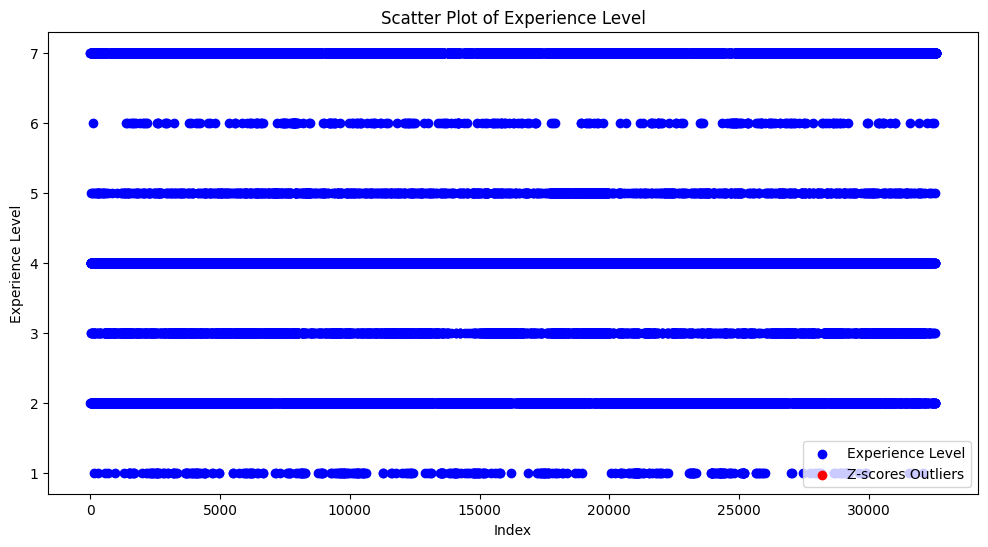

In [273]:
plt.figure(figsize=(12, 6))
plt.scatter(merged_data_cleaned.index, merged_data_cleaned['experience_level'], color='blue', label='Experience Level')

# Scatter plot for outliers
plt.scatter(outliers_z.index, outliers_z['experience_level'], color='red', label='Z-scores Outliers')
plt.title("Scatter Plot of Experience Level")
plt.xlabel("Index")
plt.ylabel("Experience Level")
plt.legend()
plt.show()

In [275]:
company_country = merged_data_cleaned['country'].unique()
company_country


array(['US', 'CA', 'FR', 'GB', '0', 'NL', 'DK', 'LI', 'JP', 'CH', 'BE',
       'SE', 'IN', 'AU', 'CN', 'DE', 'ES', 'KR', 'MT', 'IE', 'IL', 'OO',
       'IT', 'LU', 'EE', 'AT', 'BM', 'FI', 'ID', 'AE', 'AZ', 'IS', 'TW',
       'MX', 'SG', 'NO', 'HK', 'NZ', 'RU', 'BR', 'KE', 'SA', 'TR', 'GE',
       'HU', 'PR', 'UY', 'CO', 'CZ', 'AR', 'PH', 'MD'], dtype=object)

In [276]:
country_mapping = {
    'US':1,'CA':2,'FR':3,'GB':4,'0':5, 'NL':6, 'DK':7, 'LI':8, 'JP':9, 'CH':10, 'BE':11,
    'SE':12, 'IN':13, 'AU':14, 'CN':15, 'DE':16, 'ES':17, 'KR':18, 'MT':19, 'IE':20, 'IL':21, 'OO':22,
    'IT':23, 'LU':24, 'EE':25, 'AT':26, 'BM':28, 'FI':29, 'ID':29, 'AE':30, 'AZ':31, 'IS':32, 'TW':33,
    'MX':34, 'SG':35, 'NO':36, 'HK':37, 'NZ':38, 'RU':39, 'BR':40, 'KE':41, 'SA':42, 'TR':43, 'GE':45,
    'HU':46, 'PR':47, 'UY':48, 'CO':49, 'CZ':50, 'AR':51, 'PH':52, 'MD':53

}

merged_data_cleaned['country'] = merged_data_cleaned['country'].map(country_mapping)

In [277]:
merged_data

,job_id,company_id,name,location,country,skill_name,formatted_experience_level
0,3757940104,553718,HearingLife,Little River,US,Other,2
1,3757940025,2192142,Metalcraft of Mayville Inc.,Beaver Dam,US,"Management, Manufacturing",7
2,3757938019,474443,U.S. Tsubaki Power Transmission LLC,Bessemer,US,Engineering,7
3,3757938018,18213359,Episcopal Communities Services,Aliso Viejo,US,"Management, Manufacturing",2
6,3757937004,10515052,Boyd Group Services Inc.,Daytona Beach,CA,"Management, Manufacturing",2
...,...,...,...,...,...,...,...
32587,381055942,96654609,First Baptist Church Forney,Forney,US,Other,7
32588,133196985,1089558,Employvision Inc.,New York,US,"Accounting/Auditing, Finance",7
32589,133114754,77766802,CargoLogin.,Santa Clarita,US,"Sales, Business Development",7
32590,102339515,52132271,DryerVentz DuctVentz,Greater Boston,US,"Business Development, Sales",7


Checking for Outliers in Country Column

In [278]:
merged_data_cleaned['Z_Score'] = np.abs(stats.zscore(merged_data_cleaned['country'], nan_policy='omit'))
threshold = 3
outliers_z = merged_data_cleaned[merged_data_cleaned['Z_Score'] > threshold]
print("Outliers identified by Z-Score method:")
print(outliers_z.head())

Outliers identified by Z-Score method:
          job_id  company_id company     location  country  \
828   3757775332        4114  Solvay   Long Beach       11   
881   3757770838        4114  Solvay   Long Beach       11   
1007  3757758008        5328      HM  West Covina       12   
1023  3757757090        5328      HM   Costa Mesa       12   
1024  3757757089        5328      HM      Houston       12   

                              required_skill  experience_level   Z_Score  \
828   Production, Manufacturing, Engineering                 4  3.046766   
881   Production, Manufacturing, Engineering                 4  3.046766   
1007                                   Sales                 2  3.372559   
1023                                   Sales                 7  3.372559   
1024                                   Sales                 2  3.372559   

      Moving_Avg  Anomaly_Score  
828          2.9            1.1  
881          4.0            0.0  
1007         3.7            1

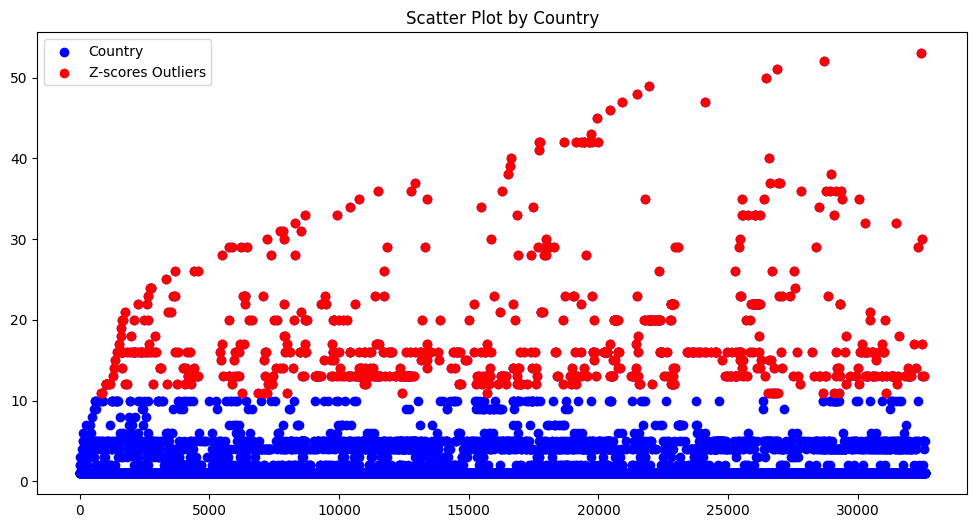

In [279]:
plt.figure(figsize=(12, 6))
plt.scatter(merged_data_cleaned.index, merged_data_cleaned['country'], color='blue', label='Country')

# Scatter plot for outliers
plt.scatter(outliers_z.index, outliers_z['country'], color='red', label='Z-scores Outliers')
plt.title("Scatter Plot by Country")
plt.legend()
plt.show()

In [281]:
country_counts = merged_data_cleaned['country'].value_counts()

# Define the percentile threshold, e.g., 95th percentile
threshold_percentile = 95

# Calculate the threshold based on the percentile
threshold_value = country_counts.quantile(q=threshold_percentile / 100)

# Identify outliers based on the threshold
outliers_dist = country_counts[country_counts < threshold_value]

print("Outliers identified by distribution rate:")
print(outliers_dist)

Outliers identified by distribution rate:
country
2     347
13    166
16    158
10    130
3     120
20     59
6      54
7      51
14     48
12     47
9      40
22     35
15     23
23     22
17     19
11     19
29     16
42     11
33     10
21      9
18      9
28      8
36      8
26      8
35      7
30      6
8       5
37      4
24      4
34      4
31      3
32      3
47      2
38      2
40      2
49      1
50      1
25      1
51      1
52      1
48      1
41      1
46      1
45      1
43      1
39      1
19      1
53      1
Name: count, dtype: int64


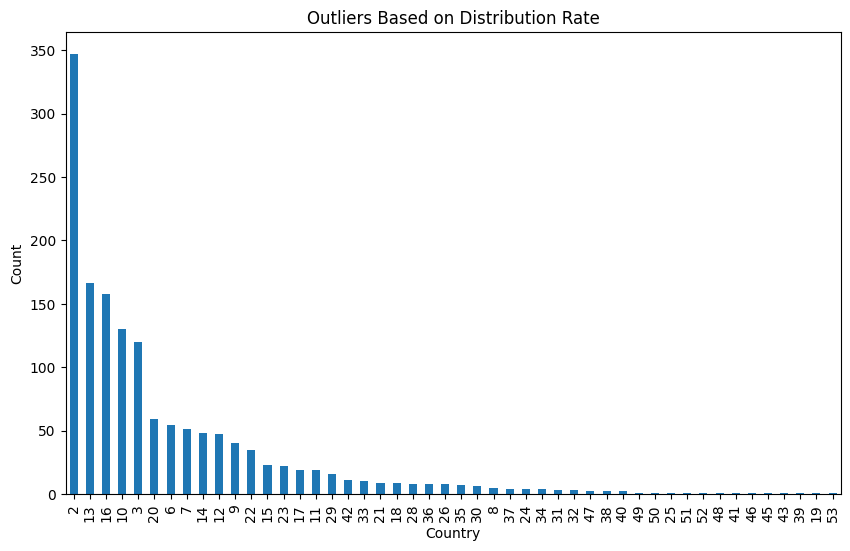

In [294]:
plt.figure(figsize=(10, 6))
outliers_dist.plot(kind='bar')
plt.title('Outliers Based on Distribution Rate')
plt.xlabel('Country')
plt.ylabel('Count')
plt.show()

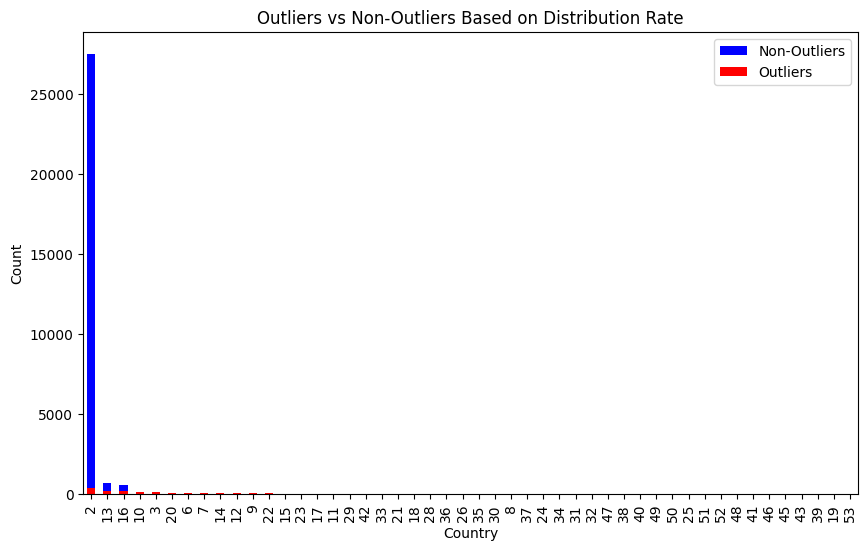

In [295]:
non_outliers = country_counts[country_counts >= threshold_value]

plt.figure(figsize=(10, 6))
non_outliers.plot(kind='bar', color='blue', label='Non-Outliers')
outliers_dist.plot(kind='bar', color='red', label='Outliers')
plt.title('Outliers vs Non-Outliers Based on Distribution Rate')
plt.xlabel('Country')
plt.ylabel('Count')
plt.legend()
plt.show()